In [1]:
import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

seed = 7

In [2]:
def plot_evals_result(evals_result):
    fig, axs = plt.subplots(1,len(set(evals_result.process_step.values,)), figsize=(15, 4))
    steps = list(evals_result.process_step.values)
    steps = sorted(set(steps), key=steps.index)
    for i,process_step in enumerate(steps):
        result = evals_result.loc[(evals_result['process_step'] == process_step),:].reset_index(drop=True)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(process_step+'_mae')
        axs[i].set_ylim(0.0, 0.1)
        axs[i].plot(range(0,len(result)), result['train_mae'], label='Train Error')
        axs[i].plot(range(0,len(result)), result['eval_mae'], label='Val Error')

def plot_TV_P_MPG(pred_result):
    fig, axs = plt.subplots(1,len(set(pred_result.process_step.values,)), figsize=(15, 4))
    steps = list(pred_result.process_step.values)
    steps = sorted(set(steps), key=steps.index)
    for i,process_step in enumerate(steps):
        test_labels = pred_result.loc[(pred_result['process_step'] == process_step),'val_labels'].values
        test_predictions = pred_result.loc[(pred_result['process_step'] == process_step),'val_predictions'].values
        axs[i].set_xlabel('True Values [MPG]')
        axs[i].set_ylabel(process_step+'_Predictions [MPG]')
        axs[i].set_ylim(0, 2)
        axs[i].set_xlim(0, 2)
        axs[i].scatter(test_labels, test_predictions)
    
def plot_PE_MPG(pred_result):
    fig, axs = plt.subplots(1,len(set(pred_result.process_step.values,)), figsize=(15, 4))
    steps = list(pred_result.process_step.values)
    steps = sorted(set(steps), key=steps.index)
    for i,process_step in enumerate(steps):
        test_labels = pred_result.loc[(pred_result['process_step'] == process_step),'val_labels'].values
        test_predictions = pred_result.loc[(pred_result['process_step'] == process_step),'val_predictions'].values
        error = test_predictions - test_labels
        error = pd.DataFrame(error,columns=['price'])
        axs[i].set_xlabel('Prediction Error [MPG]')
        axs[i].set_ylabel(process_step+'_Count')
        axs[i].set_xlim(-1, 1)
#         axs[i].set_ylim(0, 200)
        axs[i].hist(error.price.values, bins = 40)

### 一.基准模型

In [3]:
evals_result = pd.DataFrame()
pred_result = pd.DataFrame()

pcm = pd.read_csv('../tmp/train/province_city_map.csv')
pcm = pcm.loc[:,['city','province','province_id']]
car_source = pd.read_csv('../tmp/train/train.csv')
car_source.info()
# car_source = car_source.loc[:,['year','month','mile','city','price','labels','online_year','price_bn','brand_name','model_name','detail_name']]
# car_source = car_source.merge(pcm,how='left',on=['city'])
# car_source['price'] = car_source['price'] / car_source['price_bn']

# data = car_source.loc[:,['year','mile','province_id','price','online_year','price_bn']]
# train = data.sample(n=100000, random_state=seed).reset_index(drop=True)
# test = data.drop(train.index).reset_index(drop=True)
# print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95783 entries, 0 to 95782
Data columns (total 19 columns):
source_id         95783 non-null int64
origin_name       95783 non-null object
year              95783 non-null int64
month             95783 non-null float64
mile              95783 non-null float64
price             95783 non-null float64
city              95783 non-null object
domain            95783 non-null object
transfer_owner    95783 non-null float64
title             95783 non-null object
brand_slug        95783 non-null float64
model_slug        95783 non-null float64
detail_slug       95783 non-null float64
online_year       95783 non-null float64
price_bn          95783 non-null float64
brand_name        95783 non-null object
model_name        95783 non-null object
detail_name       95783 non-null object
province          95783 non-null object
dtypes: float64(9), int64(2), object(8)
memory usage: 13.9+ MB


In [4]:
dtrain = xgb.DMatrix(train.loc[:,['year','mile','province_id','online_year','price_bn']], label=train.loc[:,['price']])
dtest = xgb.DMatrix(test.loc[:,['year','mile','province_id','online_year','price_bn']], label=test.loc[:,['price']])
# specify parameters via map
param = {'booster':'gbtree','silent':1,'eta':1,'max_depth':6, 'objective':'reg:linear' }
param['eval_metric'] = 'mae'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1000
result = {}
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, evals_result=result)
temp = pd.DataFrame()
temp['train_mae'] = result['train']['mae']
temp['eval_mae'] = result['eval']['mae']
temp['process_step'] = 'base'
evals_result = evals_result.append(temp,sort=False).reset_index(drop=True)

temp = pd.DataFrame()
temp['val_labels'] = test['price']
test_predictions = bst.predict(dtest)
temp['val_predictions'] = pd.Series(test_predictions)
temp['process_step'] = 'base'
pred_result = pred_result.append(temp,sort=False).reset_index(drop=True)

[0]	eval-mae:0.061565	train-mae:0.062766
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:0.060394	train-mae:0.061354
[2]	eval-mae:0.059858	train-mae:0.060619
[3]	eval-mae:0.059624	train-mae:0.06027
[4]	eval-mae:0.059407	train-mae:0.059938
[5]	eval-mae:0.058722	train-mae:0.059201
[6]	eval-mae:0.057673	train-mae:0.058455
[7]	eval-mae:0.057482	train-mae:0.057937
[8]	eval-mae:0.056532	train-mae:0.057019
[9]	eval-mae:0.056094	train-mae:0.056455
[10]	eval-mae:0.05603	train-mae:0.05607
[11]	eval-mae:0.055952	train-mae:0.055625
[12]	eval-mae:0.055914	train-mae:0.055558
[13]	eval-mae:0.055516	train-mae:0.054919
[14]	eval-mae:0.055423	train-mae:0.054674
[15]	eval-mae:0.055268	train-mae:0.054546
[16]	eval-mae:0.055113	train-mae:0.054284
[17]	eval-mae:0.055009	train-mae:0.05401
[18]	eval-mae:0.054609	train-mae:0.053534
[19]	eval-mae:0.054502	train-mae:0.053358
[20]	eval-mae:0.054419	train-ma

[191]	eval-mae:0.045152	train-mae:0.040309
[192]	eval-mae:0.045129	train-mae:0.040285
[193]	eval-mae:0.045135	train-mae:0.040268
[194]	eval-mae:0.045128	train-mae:0.040237
[195]	eval-mae:0.045095	train-mae:0.040206
[196]	eval-mae:0.045048	train-mae:0.040157
[197]	eval-mae:0.045037	train-mae:0.040127
[198]	eval-mae:0.045031	train-mae:0.040092
[199]	eval-mae:0.045017	train-mae:0.040073
[200]	eval-mae:0.044988	train-mae:0.040028
[201]	eval-mae:0.044974	train-mae:0.039997
[202]	eval-mae:0.044956	train-mae:0.039966
[203]	eval-mae:0.04493	train-mae:0.039932
[204]	eval-mae:0.044904	train-mae:0.039902
[205]	eval-mae:0.044856	train-mae:0.03986
[206]	eval-mae:0.044861	train-mae:0.039814
[207]	eval-mae:0.044859	train-mae:0.039781
[208]	eval-mae:0.044839	train-mae:0.039749
[209]	eval-mae:0.044837	train-mae:0.039714
[210]	eval-mae:0.044813	train-mae:0.039676
[211]	eval-mae:0.044811	train-mae:0.039649
[212]	eval-mae:0.044703	train-mae:0.0396
[213]	eval-mae:0.04468	train-mae:0.039568
[214]	eval-mae:0

[383]	eval-mae:0.042082	train-mae:0.03535
[384]	eval-mae:0.04206	train-mae:0.035322
[385]	eval-mae:0.042052	train-mae:0.035303
[386]	eval-mae:0.042038	train-mae:0.035283
[387]	eval-mae:0.042032	train-mae:0.035257
[388]	eval-mae:0.042024	train-mae:0.035232
[389]	eval-mae:0.042019	train-mae:0.035208
[390]	eval-mae:0.042005	train-mae:0.035178
[391]	eval-mae:0.04198	train-mae:0.035154
[392]	eval-mae:0.041977	train-mae:0.035138
[393]	eval-mae:0.041971	train-mae:0.035123
[394]	eval-mae:0.041964	train-mae:0.035106
[395]	eval-mae:0.041943	train-mae:0.035083
[396]	eval-mae:0.041931	train-mae:0.035058
[397]	eval-mae:0.041917	train-mae:0.035039
[398]	eval-mae:0.041902	train-mae:0.035015
[399]	eval-mae:0.041906	train-mae:0.035001
[400]	eval-mae:0.041891	train-mae:0.034982
[401]	eval-mae:0.041885	train-mae:0.034963
[402]	eval-mae:0.041868	train-mae:0.03494
[403]	eval-mae:0.041853	train-mae:0.034924
[404]	eval-mae:0.041853	train-mae:0.034899
[405]	eval-mae:0.041847	train-mae:0.034878
[406]	eval-mae:

[575]	eval-mae:0.040291	train-mae:0.031984
[576]	eval-mae:0.040286	train-mae:0.031976
[577]	eval-mae:0.040272	train-mae:0.031947
[578]	eval-mae:0.040273	train-mae:0.03193
[579]	eval-mae:0.040265	train-mae:0.031913
[580]	eval-mae:0.040256	train-mae:0.031901
[581]	eval-mae:0.040238	train-mae:0.031882
[582]	eval-mae:0.040223	train-mae:0.031864
[583]	eval-mae:0.040223	train-mae:0.031857
[584]	eval-mae:0.04021	train-mae:0.03184
[585]	eval-mae:0.040187	train-mae:0.031816
[586]	eval-mae:0.040179	train-mae:0.0318
[587]	eval-mae:0.040166	train-mae:0.031784
[588]	eval-mae:0.040158	train-mae:0.031772
[589]	eval-mae:0.040149	train-mae:0.03176
[590]	eval-mae:0.040144	train-mae:0.031748
[591]	eval-mae:0.040135	train-mae:0.031731
[592]	eval-mae:0.040126	train-mae:0.031718
[593]	eval-mae:0.04012	train-mae:0.03171
[594]	eval-mae:0.040115	train-mae:0.031697
[595]	eval-mae:0.040098	train-mae:0.031679
[596]	eval-mae:0.0401	train-mae:0.031658
[597]	eval-mae:0.040077	train-mae:0.031638
[598]	eval-mae:0.0400

[767]	eval-mae:0.038954	train-mae:0.029378
[768]	eval-mae:0.038945	train-mae:0.029366
[769]	eval-mae:0.038934	train-mae:0.029354
[770]	eval-mae:0.038925	train-mae:0.029341
[771]	eval-mae:0.038907	train-mae:0.029325
[772]	eval-mae:0.03889	train-mae:0.02931
[773]	eval-mae:0.038884	train-mae:0.029296
[774]	eval-mae:0.038873	train-mae:0.029285
[775]	eval-mae:0.038862	train-mae:0.02927
[776]	eval-mae:0.038853	train-mae:0.029254
[777]	eval-mae:0.038856	train-mae:0.029246
[778]	eval-mae:0.038855	train-mae:0.029228
[779]	eval-mae:0.038847	train-mae:0.029214
[780]	eval-mae:0.038844	train-mae:0.029202
[781]	eval-mae:0.038832	train-mae:0.029187
[782]	eval-mae:0.038824	train-mae:0.029169
[783]	eval-mae:0.038823	train-mae:0.029158
[784]	eval-mae:0.038818	train-mae:0.029149
[785]	eval-mae:0.038812	train-mae:0.029137
[786]	eval-mae:0.038805	train-mae:0.029126
[787]	eval-mae:0.038807	train-mae:0.029112
[788]	eval-mae:0.038804	train-mae:0.0291
[789]	eval-mae:0.038797	train-mae:0.029091
[790]	eval-mae:0

[959]	eval-mae:0.037735	train-mae:0.027179
[960]	eval-mae:0.037734	train-mae:0.02717
[961]	eval-mae:0.037732	train-mae:0.027163
[962]	eval-mae:0.037724	train-mae:0.027148
[963]	eval-mae:0.037717	train-mae:0.027135
[964]	eval-mae:0.037711	train-mae:0.027126
[965]	eval-mae:0.037698	train-mae:0.027118
[966]	eval-mae:0.037698	train-mae:0.02711
[967]	eval-mae:0.037692	train-mae:0.027101
[968]	eval-mae:0.037686	train-mae:0.027092
[969]	eval-mae:0.03767	train-mae:0.027076
[970]	eval-mae:0.037666	train-mae:0.027066
[971]	eval-mae:0.037659	train-mae:0.027059
[972]	eval-mae:0.037653	train-mae:0.027049
[973]	eval-mae:0.037658	train-mae:0.027039
[974]	eval-mae:0.037657	train-mae:0.027031
[975]	eval-mae:0.037658	train-mae:0.027023
[976]	eval-mae:0.037652	train-mae:0.027014
[977]	eval-mae:0.037644	train-mae:0.027008
[978]	eval-mae:0.03763	train-mae:0.02699
[979]	eval-mae:0.037625	train-mae:0.026981
[980]	eval-mae:0.037615	train-mae:0.02697
[981]	eval-mae:0.037606	train-mae:0.026961
[982]	eval-mae:0.

### 二.删除离群点

In [ ]:
def cal_z_score(df):
    """
    计算z得分
    """
    return abs((df['price'] - df['mean_value']) / (df['std_value']))


def handle_data_quality(train):
    """
    处理数据质量
    """
    # 删掉price<0的记录
    train = train[train['price'] > 0]
    train = train[train['price_bn'] > 0]
    # 删掉不在20年车龄,月份1-12之外记录
    train = train[(train['year'] <= datetime.datetime.now().year)]
    train = train[train['month'].isin(list(np.arange(1, 13)))]
    return train
    
def handle_data_preprocess(train):
    """
    数据预处理
    1.删除离群点
    """
    # 删除数据量小于5的款型
    detail_num = train.groupby(['detail_slug'])['detail_name'].count().reset_index()
    detail_num = detail_num.loc[(detail_num['detail_name'] >= 5), :]
    train = train.loc[(train['detail_slug'].isin(list(set(detail_num.detail_slug.values)))), :]
    train.reset_index(inplace=True, drop=True)

    # 根据款型计算均值
    mean_value = train.groupby(['detail_slug'])['price'].mean().reset_index().rename(
        columns={'price': 'mean_value'})
    train = train.merge(mean_value, how='left', on=['detail_slug'])

    # 根据款型计算标准差
    std_value = train.groupby(['detail_slug'])['price'].std().reset_index().rename(
        columns={'price': 'std_value'})
    train = train.merge(std_value, how='left', on=['detail_slug'])

    # 计算Z得分，根据阈值删除离群点
    train['z_score'] = train.apply(cal_z_score, axis=1)
    train = train.loc[(train['z_score'] <= 1.5), :]
    train.reset_index(inplace=True, drop=True)
    train = train.drop(['mean_value', 'std_value', 'z_score'], axis=1)
    return train

In [ ]:
pcm = pd.read_csv('../tmp/train/province_city_map.csv')
pcm = pcm.loc[:,['city','province','province_id']]
car_source = pd.read_csv('../tmp/train/train.csv')
car_source.loc[(car_source['city'] == '朝阳市'),'city'] = '朝阳'
car_source.loc[(car_source['city'] == '海南州'),'city'] = '海南'
car_source = handle_data_quality(car_source)
car_source = handle_data_preprocess(car_source)
car_source = car_source.loc[:,['year','month','mile','city','price','labels','online_year','price_bn','brand_name','model_name','detail_name']]
car_source = car_source.merge(pcm,how='left',on=['city'])

data = car_source.loc[:,['year','mile','province_id','price','online_year','price_bn']]
train = data.sample(n=100000, random_state=seed).reset_index(drop=True)
test = data.drop(train.index).reset_index(drop=True)
print(train.info(),test.info())

In [ ]:
dtrain = xgb.DMatrix(train.loc[:,['year','mile','province_id','online_year','price_bn']], label=train.loc[:,['price']])
dtest = xgb.DMatrix(test.loc[:,['year','mile','province_id','online_year','price_bn']], label=test.loc[:,['price']])
# specify parameters via map
param = {'booster':'gbtree','silent':1,'eta':1,'max_depth':6, 'objective':'reg:linear' }
param['eval_metric'] = 'mae'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1000
result = {}
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, evals_result=result)
temp = pd.DataFrame()
temp['train_mae'] = result['train']['mae']
temp['eval_mae'] = result['eval']['mae']
temp['process_step'] = 'del_outlier'
evals_result = evals_result.append(temp,sort=False).reset_index(drop=True)

temp = pd.DataFrame()
temp['val_labels'] = test['price']
test_predictions = bst.predict(dtest)
temp['val_predictions'] = pd.Series(test_predictions)
temp['process_step'] = 'del_outlier'
pred_result = pred_result.append(temp,sort=False).reset_index(drop=True)

### 三.特征工程

In [5]:
pcm = pd.read_csv('../tmp/train/province_city_map.csv')
pcm = pcm.loc[:,['city','province','province_id']]
car_source = pd.read_csv('../tmp/train/train.csv')
car_source.loc[(car_source['city'] == '朝阳市'),'city'] = '朝阳'
car_source.loc[(car_source['city'] == '海南州'),'city'] = '海南'

global_model_mean = pd.read_csv('../tmp/train/autohome_global_model_mean.csv')
# 取低配数据
low_config_car = global_model_mean.loc[global_model_mean.groupby(['brand_slug', 'model_slug', 'online_year']).price_bn.idxmin(), :].reset_index(drop=True)
low_config_car = low_config_car.loc[:,['brand_slug','model_slug','online_year','price_bn','median_price']]    
low_config_car = low_config_car.rename(columns={'median_price':'low_config_price','price_bn':'low_config_price_bn'})
# car_source = handle_data_quality(car_source)
# car_source = handle_data_preprocess(car_source)
car_source = car_source.merge(low_config_car,how='left',on=['brand_slug','model_slug','online_year'])
car_source = car_source.loc[:,['title','detail_slug','year','month','mile','city','price','labels','online_year','price_bn','brand_name','model_name','detail_name','low_config_price','low_config_price_bn']]
car_source = car_source.merge(pcm,how='left',on=['city'])

car_source = car_source.loc[(car_source['price'] >= car_source['low_config_price']),:].reset_index(drop=True)

car_source['used_years'] = datetime.datetime.now().year - car_source['online_year']
car_source['warehouse_years'] = car_source['year'] - car_source['online_year']
car_source['div_price_bn'] = car_source['price_bn'] - car_source['low_config_price_bn']
car_source['price'] = car_source['price'] / car_source['price_bn']
# data = car_source.loc[:,['detail_slug','used_years','warehouse_years','province_id','price','price_bn','low_config_price','div_price_bn']]
data = car_source.loc[:,['detail_slug','used_years','warehouse_years','price','price_bn','low_config_price','div_price_bn']]
train = data.sample(n=100000, random_state=seed).reset_index(drop=True)
test = data.drop(train.index).reset_index(drop=True)
print(train.info(),test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
detail_slug         100000 non-null float64
used_years          100000 non-null float64
warehouse_years     100000 non-null float64
price               100000 non-null float64
price_bn            100000 non-null float64
low_config_price    100000 non-null float64
div_price_bn        100000 non-null float64
dtypes: float64(7)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32741 entries, 0 to 32740
Data columns (total 7 columns):
detail_slug         32741 non-null float64
used_years          32741 non-null float64
warehouse_years     32741 non-null float64
price               32741 non-null float64
price_bn            32741 non-null float64
low_config_price    32741 non-null float64
div_price_bn        32741 non-null float64
dtypes: float64(7)
memory usage: 1.7 MB
None None


In [6]:
columns = list(train.columns)
columns.remove('price')
columns.remove('detail_slug')
dtrain = xgb.DMatrix(train.loc[:,columns], label=train.loc[:,['price']])
dtest = xgb.DMatrix(test.loc[:,columns], label=test.loc[:,['price']])
# specify parameters via map
param = {'booster':'gbtree','silent':1,'eta':1,'max_depth':6, 'objective':'reg:linear' }
param['eval_metric'] = 'mae'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1000
result = {}
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, evals_result=result)
temp = pd.DataFrame()
temp['train_mae'] = result['train']['mae']
temp['eval_mae'] = result['eval']['mae']
temp['process_step'] = 'fe'
evals_result = evals_result.append(temp,sort=False).reset_index(drop=True)
# evals_result_copy = evals_result.append(temp,sort=False).reset_index(drop=True)

temp = pd.DataFrame()
temp['val_labels'] = test['price']
test_predictions = bst.predict(dtest)
temp['val_predictions'] = pd.Series(test_predictions)
temp['process_step'] = 'fe'
pred_result = pred_result.append(temp,sort=False).reset_index(drop=True)
# pred_result_copy = pred_result.append(temp,sort=False).reset_index(drop=True)

[0]	eval-mae:0.05292	train-mae:0.056827
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:0.049546	train-mae:0.052659
[2]	eval-mae:0.047132	train-mae:0.049359
[3]	eval-mae:0.045422	train-mae:0.047114
[4]	eval-mae:0.04469	train-mae:0.046101
[5]	eval-mae:0.043918	train-mae:0.044976
[6]	eval-mae:0.043007	train-mae:0.043814
[7]	eval-mae:0.042078	train-mae:0.042845
[8]	eval-mae:0.04147	train-mae:0.04219
[9]	eval-mae:0.041291	train-mae:0.041788
[10]	eval-mae:0.04094	train-mae:0.041402
[11]	eval-mae:0.040605	train-mae:0.040877
[12]	eval-mae:0.040498	train-mae:0.040618
[13]	eval-mae:0.040216	train-mae:0.04027
[14]	eval-mae:0.040063	train-mae:0.040008
[15]	eval-mae:0.039972	train-mae:0.039677
[16]	eval-mae:0.039816	train-mae:0.039458
[17]	eval-mae:0.039738	train-mae:0.03935
[18]	eval-mae:0.039625	train-mae:0.039195
[19]	eval-mae:0.039316	train-mae:0.038828
[20]	eval-mae:0.039097	train-mae:0

[191]	eval-mae:0.033182	train-mae:0.032131
[192]	eval-mae:0.033177	train-mae:0.032126
[193]	eval-mae:0.033178	train-mae:0.032119
[194]	eval-mae:0.033175	train-mae:0.032112
[195]	eval-mae:0.033164	train-mae:0.032099
[196]	eval-mae:0.033147	train-mae:0.032087
[197]	eval-mae:0.03314	train-mae:0.032072
[198]	eval-mae:0.033121	train-mae:0.032063
[199]	eval-mae:0.033115	train-mae:0.032057
[200]	eval-mae:0.033114	train-mae:0.032049
[201]	eval-mae:0.033103	train-mae:0.032033
[202]	eval-mae:0.0331	train-mae:0.032022
[203]	eval-mae:0.033093	train-mae:0.032009
[204]	eval-mae:0.033088	train-mae:0.032
[205]	eval-mae:0.033079	train-mae:0.031992
[206]	eval-mae:0.033077	train-mae:0.03198
[207]	eval-mae:0.033072	train-mae:0.031972
[208]	eval-mae:0.033064	train-mae:0.031964
[209]	eval-mae:0.033063	train-mae:0.031963
[210]	eval-mae:0.033056	train-mae:0.03195
[211]	eval-mae:0.033056	train-mae:0.031943
[212]	eval-mae:0.033055	train-mae:0.031939
[213]	eval-mae:0.033048	train-mae:0.031929
[214]	eval-mae:0.03

[383]	eval-mae:0.032384	train-mae:0.031049
[384]	eval-mae:0.032386	train-mae:0.031047
[385]	eval-mae:0.032382	train-mae:0.031044
[386]	eval-mae:0.032382	train-mae:0.031043
[387]	eval-mae:0.032377	train-mae:0.031039
[388]	eval-mae:0.032371	train-mae:0.031036
[389]	eval-mae:0.03237	train-mae:0.031033
[390]	eval-mae:0.032369	train-mae:0.031031
[391]	eval-mae:0.032369	train-mae:0.03103
[392]	eval-mae:0.03237	train-mae:0.031024
[393]	eval-mae:0.032364	train-mae:0.031021
[394]	eval-mae:0.032364	train-mae:0.031016
[395]	eval-mae:0.032361	train-mae:0.031014
[396]	eval-mae:0.03236	train-mae:0.031013
[397]	eval-mae:0.03236	train-mae:0.031009
[398]	eval-mae:0.032351	train-mae:0.031004
[399]	eval-mae:0.032351	train-mae:0.031
[400]	eval-mae:0.032353	train-mae:0.030999
[401]	eval-mae:0.032352	train-mae:0.030996
[402]	eval-mae:0.032353	train-mae:0.030995
[403]	eval-mae:0.03235	train-mae:0.030993
[404]	eval-mae:0.032348	train-mae:0.030991
[405]	eval-mae:0.032346	train-mae:0.030989
[406]	eval-mae:0.032

[575]	eval-mae:0.032086	train-mae:0.030627
[576]	eval-mae:0.032084	train-mae:0.030626
[577]	eval-mae:0.03208	train-mae:0.030622
[578]	eval-mae:0.032079	train-mae:0.030621
[579]	eval-mae:0.032079	train-mae:0.03062
[580]	eval-mae:0.032078	train-mae:0.03062
[581]	eval-mae:0.032078	train-mae:0.030618
[582]	eval-mae:0.032075	train-mae:0.030616
[583]	eval-mae:0.032071	train-mae:0.030612
[584]	eval-mae:0.03207	train-mae:0.030611
[585]	eval-mae:0.03207	train-mae:0.03061
[586]	eval-mae:0.032066	train-mae:0.030608
[587]	eval-mae:0.032064	train-mae:0.030606
[588]	eval-mae:0.032064	train-mae:0.030605
[589]	eval-mae:0.032061	train-mae:0.030605
[590]	eval-mae:0.03206	train-mae:0.030604
[591]	eval-mae:0.032057	train-mae:0.030602
[592]	eval-mae:0.032057	train-mae:0.030601
[593]	eval-mae:0.032054	train-mae:0.030599
[594]	eval-mae:0.032051	train-mae:0.030597
[595]	eval-mae:0.032051	train-mae:0.030595
[596]	eval-mae:0.032051	train-mae:0.030594
[597]	eval-mae:0.032051	train-mae:0.030593
[598]	eval-mae:0.0

[767]	eval-mae:0.031906	train-mae:0.03038
[768]	eval-mae:0.031905	train-mae:0.03038
[769]	eval-mae:0.031904	train-mae:0.030378
[770]	eval-mae:0.031903	train-mae:0.030377
[771]	eval-mae:0.031902	train-mae:0.030376
[772]	eval-mae:0.031902	train-mae:0.030376
[773]	eval-mae:0.031902	train-mae:0.030374
[774]	eval-mae:0.031901	train-mae:0.030373
[775]	eval-mae:0.031901	train-mae:0.030372
[776]	eval-mae:0.0319	train-mae:0.030371
[777]	eval-mae:0.0319	train-mae:0.030371
[778]	eval-mae:0.0319	train-mae:0.03037
[779]	eval-mae:0.031899	train-mae:0.030369
[780]	eval-mae:0.031899	train-mae:0.030369
[781]	eval-mae:0.031898	train-mae:0.030368
[782]	eval-mae:0.031899	train-mae:0.030367
[783]	eval-mae:0.031898	train-mae:0.030366
[784]	eval-mae:0.031898	train-mae:0.030365
[785]	eval-mae:0.031898	train-mae:0.030364
[786]	eval-mae:0.031897	train-mae:0.030364
[787]	eval-mae:0.031895	train-mae:0.030362
[788]	eval-mae:0.031895	train-mae:0.030361
[789]	eval-mae:0.031894	train-mae:0.03036
[790]	eval-mae:0.0318

[959]	eval-mae:0.031813	train-mae:0.03024
[960]	eval-mae:0.031813	train-mae:0.030239
[961]	eval-mae:0.031812	train-mae:0.030238
[962]	eval-mae:0.031812	train-mae:0.030237
[963]	eval-mae:0.031811	train-mae:0.030237
[964]	eval-mae:0.03181	train-mae:0.030236
[965]	eval-mae:0.031809	train-mae:0.030235
[966]	eval-mae:0.031807	train-mae:0.030234
[967]	eval-mae:0.031807	train-mae:0.030234
[968]	eval-mae:0.031807	train-mae:0.030233
[969]	eval-mae:0.031806	train-mae:0.030233
[970]	eval-mae:0.031807	train-mae:0.030232
[971]	eval-mae:0.031806	train-mae:0.030232
[972]	eval-mae:0.031805	train-mae:0.030231
[973]	eval-mae:0.031805	train-mae:0.03023
[974]	eval-mae:0.031804	train-mae:0.03023
[975]	eval-mae:0.031803	train-mae:0.030229
[976]	eval-mae:0.031803	train-mae:0.030229
[977]	eval-mae:0.031804	train-mae:0.030229
[978]	eval-mae:0.031804	train-mae:0.030228
[979]	eval-mae:0.031804	train-mae:0.030228
[980]	eval-mae:0.031803	train-mae:0.030227
[981]	eval-mae:0.031802	train-mae:0.030227
[982]	eval-mae:

### 四.超参数调整

In [ ]:
paramGrid = {"max_depth" : [8],
             "learning_rate" : [0.1],
             "n_estimators" : [100],
             "colsample_by*" : [1, 0.9, 0.8],
             "reg_alpha" : [0, 0.1, 0.2],
             "reg_lambda" : [1, 0.9, 0.8],
            }
                

fit_params={"early_stopping_rounds":10, 
            "eval_metric" : "mae", 
            "eval_set" : [[test.loc[:,columns], test.loc[:,['price']]]]}

model = xgb.XGBRegressor()
gridsearch = GridSearchCV(model, paramGrid, verbose=1 ,
         fit_params=fit_params,cv=5)
gridsearch.fit(train.loc[:,columns],train.loc[:,['price']])

print("Best parameters set found on development set:")
print()
print(gridsearch.best_params_)
print()
print("Grid scores on development set:")
print()
means = gridsearch.cv_results_['mean_test_score']
stds = gridsearch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridsearch.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [26]:
columns = list(train.columns)
columns.remove('price')
columns.remove('detail_slug')
dtrain = xgb.DMatrix(train.loc[:,columns], label=train.loc[:,['price']])
dtest = xgb.DMatrix(test.loc[:,columns], label=test.loc[:,['price']])
# specify parameters via map
param = {'booster':'gbtree','silent':1,'eta':1,'max_depth':10, 'objective':'reg:linear', 'reg_alpha':0.1 }
param['eval_metric'] = 'mae'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1000
result = {}
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, evals_result=result)
temp = pd.DataFrame()
temp['train_mae'] = result['train']['mae']
temp['eval_mae'] = result['eval']['mae']
temp['process_step'] = 'param'
# evals_result = evals_result.append(temp,sort=False).reset_index(drop=True)
evals_result_copy = evals_result.append(temp,sort=False).reset_index(drop=True)

temp = pd.DataFrame()
temp['val_labels'] = test['price']
test_predictions = bst.predict(dtest)
temp['val_predictions'] = pd.Series(test_predictions)
temp['process_step'] = 'param'
# pred_result = pred_result.append(temp,sort=False).reset_index(drop=True)
pred_result_copy = pred_result.append(temp,sort=False).reset_index(drop=True)

[0]	eval-mae:0.043074	train-mae:0.043468
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:0.040706	train-mae:0.040596
[2]	eval-mae:0.039271	train-mae:0.038919
[3]	eval-mae:0.038435	train-mae:0.037868
[4]	eval-mae:0.037197	train-mae:0.036706
[5]	eval-mae:0.036888	train-mae:0.036272
[6]	eval-mae:0.036012	train-mae:0.035461
[7]	eval-mae:0.035639	train-mae:0.035138
[8]	eval-mae:0.035488	train-mae:0.034875
[9]	eval-mae:0.035448	train-mae:0.034745
[10]	eval-mae:0.035107	train-mae:0.034375
[11]	eval-mae:0.034989	train-mae:0.034216
[12]	eval-mae:0.034647	train-mae:0.033858
[13]	eval-mae:0.034497	train-mae:0.033659
[14]	eval-mae:0.034465	train-mae:0.033617
[15]	eval-mae:0.03434	train-mae:0.033448
[16]	eval-mae:0.034152	train-mae:0.033246
[17]	eval-mae:0.034024	train-mae:0.033094
[18]	eval-mae:0.033942	train-mae:0.032947
[19]	eval-mae:0.033876	train-mae:0.032861
[20]	eval-mae:0.033749	train

[191]	eval-mae:0.032091	train-mae:0.030744
[192]	eval-mae:0.03209	train-mae:0.030742
[193]	eval-mae:0.032091	train-mae:0.030741
[194]	eval-mae:0.032091	train-mae:0.030741
[195]	eval-mae:0.032088	train-mae:0.030738
[196]	eval-mae:0.032087	train-mae:0.030737
[197]	eval-mae:0.032087	train-mae:0.030737
[198]	eval-mae:0.032087	train-mae:0.030736
[199]	eval-mae:0.032086	train-mae:0.030734
[200]	eval-mae:0.032084	train-mae:0.030733
[201]	eval-mae:0.032083	train-mae:0.030732
[202]	eval-mae:0.032083	train-mae:0.030731
[203]	eval-mae:0.032082	train-mae:0.03073
[204]	eval-mae:0.032082	train-mae:0.030729
[205]	eval-mae:0.032081	train-mae:0.030728
[206]	eval-mae:0.03208	train-mae:0.030727
[207]	eval-mae:0.032078	train-mae:0.030726
[208]	eval-mae:0.032077	train-mae:0.030725
[209]	eval-mae:0.032078	train-mae:0.030724
[210]	eval-mae:0.032077	train-mae:0.030723
[211]	eval-mae:0.032076	train-mae:0.030723
[212]	eval-mae:0.032075	train-mae:0.030722
[213]	eval-mae:0.032074	train-mae:0.03072
[214]	eval-mae:

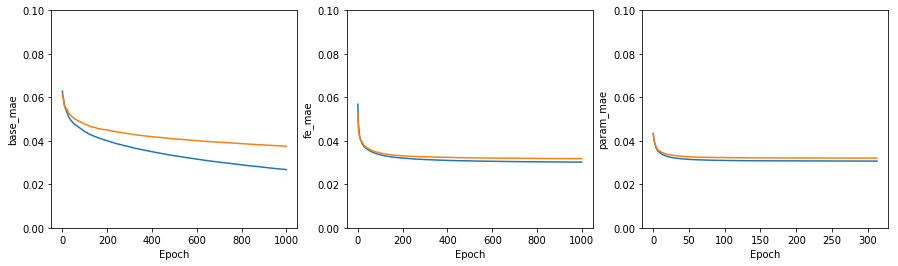

In [27]:
data = evals_result_copy.copy()
plot_evals_result(data)

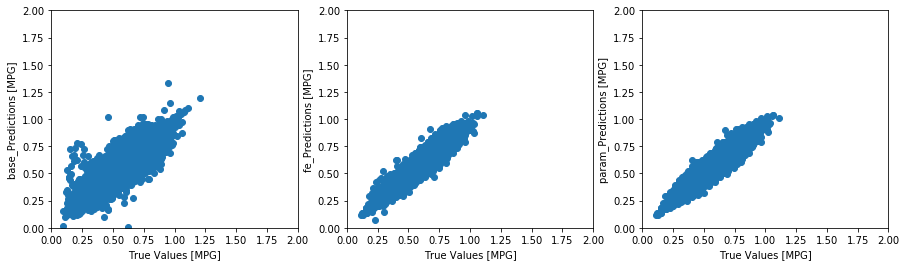

In [28]:
data = pred_result_copy.copy()
plot_TV_P_MPG(data)

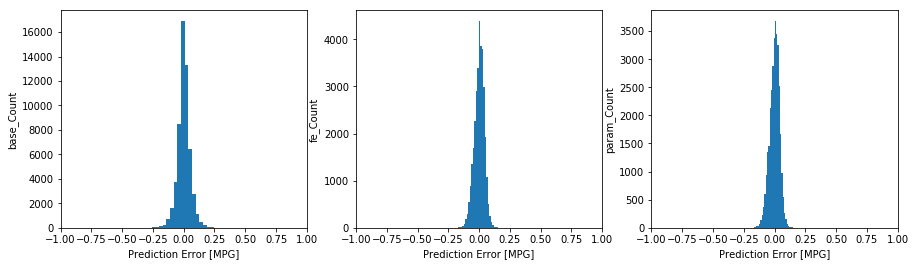

In [29]:
data = pred_result_copy.copy()
plot_PE_MPG(data)

### 五.跟上一版本对比

In [20]:
global_model_mean = pd.read_csv('../tmp/train/autohome_global_model_mean.csv')
# 取低配数据
low_config_car = global_model_mean.loc[global_model_mean.groupby(['brand_slug', 'model_slug', 'online_year']).price_bn.idxmin(), :].reset_index(drop=True)
low_config_car = low_config_car.loc[:,['brand_slug','model_slug','online_year','price_bn','median_price']]    
low_config_car = low_config_car.rename(columns={'median_price':'low_config_price','price_bn':'low_config_price_bn'})

new_version_prediction = global_model_mean.merge(low_config_car,how='left',on=['brand_slug','model_slug','online_year'])
new_version_prediction['warehouse_years'] = 0
new_version_prediction['div_price_bn'] = new_version_prediction['price_bn'] - new_version_prediction['low_config_price_bn']
dtest = xgb.DMatrix(new_version_prediction.loc[:,columns])
test_predictions = bst.predict(dtest)
new_version_prediction['new_prediction'] = pd.Series(test_predictions)
new_version_prediction['new_prediction'] = new_version_prediction['new_prediction'] * new_version_prediction['price_bn']
new_version_prediction = new_version_prediction.drop(['brand_slug','model_slug','manufacturer','listed_year','online_year'],axis=1)
new_version_prediction.to_csv('../tmp/train/man.csv',index=False)
new_version_prediction.head()

,detail_slug,brand_name,model_name,detail_name,price_bn,body,energy,used_years,median_price,low_config_price_bn,low_config_price,warehouse_years,div_price_bn,new_prediction
0,4179,大众,捷达,2008款 CIX-P伙伴型,7.48,紧凑型车,汽油,11,1.82,7.48,1.82,0,0.0,2.382622
1,4762,大众,捷达,2008款 CiF-P 伙伴,7.48,紧凑型车,汽油,11,1.82,7.48,1.82,0,0.0,2.382622
2,4764,大众,捷达,2008款 GiF 前卫,8.78,紧凑型车,汽油,11,1.86,7.48,1.82,0,1.3,2.128871
3,1170,大众,捷达,2008款 CIF 春天型,8.98,紧凑型车,汽油,11,1.86,7.48,1.82,0,1.5,1.979227
4,4181,大众,捷达,2008款 GIF 前卫型,9.68,紧凑型车,汽油,11,1.88,7.48,1.82,0,2.2,2.951428


In [17]:
columns

['used_years',
 'warehouse_years',
 'price_bn',
 'low_config_price',
 'div_price_bn']

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32741 entries, 0 to 32740
Data columns (total 7 columns):
detail_slug         32741 non-null float64
used_years          32741 non-null float64
warehouse_years     32741 non-null float64
price               32741 non-null float64
price_bn            32741 non-null float64
low_config_price    32741 non-null float64
div_price_bn        32741 non-null float64
dtypes: float64(7)
memory usage: 1.7 MB


In [ ]:
verify = pred_result_copy.loc[(pred_result_copy['process_step'] == 'param'),:].reset_index(drop=True)
man = test.copy()
man['prediction'] = verify['val_predictions'] 
man['prediction'] = man['prediction'] * man['price_bn']
man['price'] = man['price'] * man['price_bn']
man['loss'] = (man['prediction'] - man['price']) / man['price']
man.loc[(abs(man['loss']) > 0.05),:]

In [ ]:
man1 = man.loc[(abs(man['loss']) > 2.5),:]
man1 = man1.groupby(['detail_slug'])['used_years'].count().reset_index()
man1.loc[(man1['used_years'] > 2),:]

In [ ]:
man.loc[(man['detail_slug'] == 27914),:]

In [ ]:
car_source.loc[(abs(car_source['price_bn']) > 140),:]

In [ ]:
car_source = pd.read_csv('../tmp/train/train.csv')
car_source = car_source.drop(['color','car_application','source_id','id','brand_name','model_name','detail_name','annual_insurance','compulsory_insurance','business_insurance'],axis=1)
car_source.loc[(car_source['detail_slug'] == 26563),:]

In [ ]:
xgb.plot_importance(bst)

In [ ]:
xgb.to_graphviz(bst, num_trees=100)

In [ ]:
xgb.to_graphviz?